In [38]:
using JuMP
using DecisionProgramming

In [50]:
N = 5
diagram = InfluenceDiagram()

add_node!(diagram, ChanceNode("h1", [], ["ill", "healthy"])) # creates initial health state with no information state

for i in 1:N-1
    add_node!(diagram, ChanceNode("t$i", ["h$i"], ["positive", "negative"])) # test result
    add_node!(diagram, DecisionNode("d$i", ["t$i"], ["treat", "not treat"])) # treatment decision
    add_node!(diagram, ValueNode("u$i", ["d$i"])) # test cost
    add_node!(diagram, ChanceNode("h$(i+1)", ["h$i", "d$i"], ["ill", "healthy"])) # health state in next period
end 

add_node!(diagram, ValueNode("u$N", ["h$N"])) # value node with market value

generate_arcs!(diagram)

diagram

InfluenceDiagram(AbstractNode[ChanceNode("h1", String[], ["ill", "healthy"]), ChanceNode("t1", ["h1"], ["positive", "negative"]), DecisionNode("d1", ["t1"], ["treat", "not treat"]), ValueNode("u1", ["d1"]), ChanceNode("h2", ["h1", "d1"], ["ill", "healthy"]), ChanceNode("t2", ["h2"], ["positive", "negative"]), DecisionNode("d2", ["t2"], ["treat", "not treat"]), ValueNode("u2", ["d2"]), ChanceNode("h3", ["h2", "d2"], ["ill", "healthy"]), ChanceNode("t3", ["h3"], ["positive", "negative"]), DecisionNode("d3", ["t3"], ["treat", "not treat"]), ValueNode("u3", ["d3"]), ChanceNode("h4", ["h3", "d3"], ["ill", "healthy"]), ChanceNode("t4", ["h4"], ["positive", "negative"]), DecisionNode("d4", ["t4"], ["treat", "not treat"]), ValueNode("u4", ["d4"]), ChanceNode("h5", ["h4", "d4"], ["ill", "healthy"]), ValueNode("u5", ["h5"])], ["h1", "t1", "d1", "h2", "t2", "d2", "h3", "t3", "d3", "h4", "t4", "d4", "h5", "u1", "u2", "u3", "u4", "u5"], Vector{Int16}[[], [1], [2], [1, 3], [4], [5], [4, 6], [7], [8]

In [51]:
add_probabilities!(diagram, "h1", [0.1, 0.9]) # initial health state probability

# probablity matrix specifying health conditions given previous health and treatment decision
X_h = ProbabilityMatrix(diagram, "h2")
X_h["healthy", "not treat", :] = [0.2, 0.8]
X_h["healthy", "treat", :] = [0.1, 0.9]
X_h["ill", "not treat", :] = [0.9, 0.1]
X_h["ill", "treat", :] = [0.5, 0.5]

X_h

2×2×2 ProbabilityMatrix{3}:
[:, :, 1] =
 0.5  0.9
 0.1  0.2

[:, :, 2] =
 0.5  0.1
 0.9  0.8

In [52]:
X_t = ProbabilityMatrix(diagram, "t1")
X_t["ill", "positive"] = 0.8
X_t["ill", "negative"] = 0.2
X_t["healthy", "negative"] = 0.9
X_t["healthy", "positive"] = 0.1

X_t

2×2 ProbabilityMatrix{2}:
 0.8  0.2
 0.1  0.9

In [53]:
for i in 1:N-1
    add_probabilities!(diagram, "t$i", X_t)
    add_probabilities!(diagram, "h$(i+1)", X_h)
end

In [54]:
for i in 1:N-1
    add_utilities!(diagram, "u$i", [-100.0, 0.0])
end

add_utilities!(diagram, "u$N", [300.0, 1000.0]);

In [55]:
generate_diagram!(diagram, positive_path_utility=true);

In [56]:
using Gurobi

SOLVER = Gurobi

model = Model(SOLVER.Optimizer)

z = DecisionVariables(model, diagram)
x_s = PathCompatibilityVariables(model, diagram, z, probability_cut = false)

expected_profit = expected_value(model, diagram, x_s)
@objective(model, Max, expected_profit)

model

Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-03


A JuMP Model
Maximization problem with:
Variables: 8208
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 8 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 16 constraints
`AffExpr`-in-`MathOptInterface.Interval{Float64}`: 8192 constraints
`VariableRef`-in-`MathOptInterface.ZeroOne`: 16 constraints
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: Gurobi

In [57]:
optimize!(model)

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads
Optimize a model with 8216 rows, 16400 columns and 49184 nonzeros
Model fingerprint: 0xef89896f
Variable types: 16384 continuous, 16 integer (16 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+02]
  Objective range  [1e-07, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 8200 rows and 10230 columns
Presolve time: 0.02s
Presolved: 16 rows, 6170 columns, 24664 nonzeros
Variable types: 6162 continuous, 8 integer (8 binary)

Root relaxation: objective 9.212444e+03, 42 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 9212.44416    0    8   -0.00000 9212.44416      -     -    0s
     0     0 9212

In [58]:
# Retriving solution elements
Z = DecisionStrategy(z)
S_probabilities = StateProbabilities(diagram, Z)
U_distribution = UtilityDistribution(diagram, Z);

print_decision_strategy(diagram, Z, S_probabilities)

┌────────────────┬────────────────┐
│ State(s) of t1 │ Decision in d1 │
├────────────────┼────────────────┤
│ positive       │ not treat      │
│ negative       │ not treat      │
└────────────────┴────────────────┘
┌────────────────┬────────────────┐
│ State(s) of t2 │ Decision in d2 │
├────────────────┼────────────────┤
│ positive       │ not treat      │
│ negative       │ not treat      │
└────────────────┴────────────────┘
┌────────────────┬────────────────┐
│ State(s) of t3 │ Decision in d3 │
├────────────────┼────────────────┤
│ positive       │ treat          │
│ negative       │ not treat      │
└────────────────┴────────────────┘
┌────────────────┬────────────────┐
│ State(s) of t4 │ Decision in d4 │
├────────────────┼────────────────┤
│ positive       │ treat          │
│ negative       │ not treat      │
└────────────────┴────────────────┘


In [59]:
print_utility_distribution(U_distribution)
print_statistics(U_distribution)

┌─────────────┬─────────────┐
│     Utility │ Probability │
│     Float64 │     Float64 │
├─────────────┼─────────────┤
│  100.000000 │    0.066790 │
│  200.000000 │    0.143491 │
│  300.000000 │    0.112986 │
│  800.000000 │    0.083637 │
│  900.000000 │    0.267152 │
│ 1000.000000 │    0.325944 │
└─────────────┴─────────────┘
┌──────────┬────────────┐
│     Name │ Statistics │
│   String │    Float64 │
├──────────┼────────────┤
│     Mean │ 702.563470 │
│      Std │ 344.740067 │
│ Skewness │  -0.719700 │
│ Kurtosis │  -1.308574 │
└──────────┴────────────┘


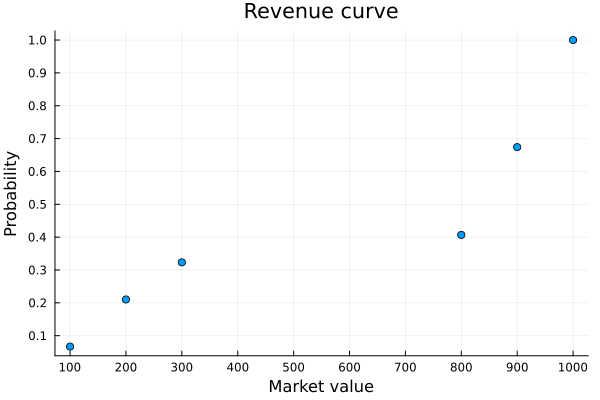

In [61]:
using Plots
p_cumulative = [sum(U_distribution.p[1:i]) for i = 1:length(U_distribution.p)]
scatter(U_distribution.u, p_cumulative,
    label = false,
    xaxis = ("Market value", 0:100:1000),
    yaxis = ("Probability", 0.0:0.1:1.0),
    title = "Revenue curve" 
    )
